<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)</br>
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Final')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

#DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/Colab Notebooks/Final'
%ls

/content/gdrive/My Drive/Colab Notebooks/Final
 beheaded_inception3.py   handout.tar             'Sampling example.png'
 best_model_1.pt          image_captionong.ipynb   soccer.jpg
 best_model_att_1.pt      img.jpg                 'Telegram bot'/
 cat_dog.jpg             'Imgs '/                  tony_hawk.jpg
 coco_images.h5           NNattention.jpg          Ubuntu-Regular.ttf
 coco_img_arrays/         NNBasestructure.png      vocab_att.npy
 cycler.jpg               pdf/                     vocab.npy
 data/                    putin.jpg                words.txt
 grandpa.jpg              __pycache__/


In [3]:
import numpy as np
import json

# загружаем датасет
json_train = json.load(open('data/COCO data as is/captions_train2017.json'))
json_val   = json.load(open('data/COCO data as is/captions_val2017.json'))

Let's investigate json file data structure

In [4]:
json_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations'])

In [5]:
json_train['images'][0]

{'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'date_captured': '2013-11-14 11:18:45',
 'file_name': '000000391895.jpg',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'height': 360,
 'id': 391895,
 'license': 3,
 'width': 640}

In [6]:
json_train['annotations'][0]

{'caption': 'A bicycle replica with a clock as the front wheel.',
 'id': 37,
 'image_id': 203564}

In [7]:
print('dataset size: {}\n' \
      'Train: {}\n'\
      'Val: {}\n'.format(len(json_train['images'])+len(json_val['images']),
                       len(json_train['images']),
                       len(json_val['images'])))

dataset size: 123287
Train: 118287
Val: 5000



In [8]:
from nltk import wordpunct_tokenize
from tqdm.notebook import tqdm

id2img_train = {}
id2cap_train = {}

id2img_val = {}
id2cap_val = {}

for ann in tqdm(json_val['annotations']):
    if ann['image_id'] not in id2cap_val.keys():
        id2cap_val[ann['image_id']] = []
    sent = ' '.join(wordpunct_tokenize(ann['caption'].lower()))
    id2cap_val[ann['image_id']].append(sent)

for ann in tqdm(json_train['annotations']):
    if ann['image_id'] not in id2cap_train.keys():
        id2cap_train[ann['image_id']] = []
    sent = ' '.join(wordpunct_tokenize(ann['caption'].lower()))
    id2cap_train[ann['image_id']].append(sent)

for img in tqdm(json_val['images']):
    id2img_val[img['id']] = img['file_name']

for img in tqdm(json_train['images']):
    id2img_train[img['id']] = img['file_name']

#id2cap

  0%|          | 0/25014 [00:00<?, ?it/s]

  0%|          | 0/591753 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/118287 [00:00<?, ?it/s]

In [9]:
sorted_ids_train = sorted(id2img_train.keys())
sorted_ids_val   = sorted(id2img_val.keys())

captions_train = [id2cap_train[key] for key in sorted_ids_train]
captions_val = [id2cap_val[key] for key in sorted_ids_val]

img_name_train = [id2img_train[key] for key in sorted_ids_train]
img_name_val = [id2img_val[key] for key in sorted_ids_val]

In [10]:
print('http://images.cocodataset.org/train2017/'+img_name_train[32])
captions_train[32]

http://images.cocodataset.org/train2017/000000000154.jpg


['three zeebras standing in a grassy field walking',
 'three zebras are standing in an open field .',
 'three zebra are walking through the grass of a field .',
 'three zebras standing on a grassy dirt field .',
 'three zebras grazing in green grass field area .']

In [11]:
print('http://images.cocodataset.org/val2017/'+img_name_val[32])
captions_val[32]

http://images.cocodataset.org/val2017/000000002592.jpg


['decorated coffee cup and knife sitting on a patterned surface .',
 'a large knife is sitting in front of a mug has a skull and crossbones .',
 'a white mug showing pirate skull and bones and a large knife on a counter top .',
 'there is a white coffee cup with a skull and bones on it next to a knife',
 'a close up of a knife and a cup on a surface']

In [12]:
class Vocabulary:
    def __init__(self, corpus, thr=5, trash_words=["..", "...", "\\", "`", ">"]):
        """
        :param corpus: corpus of words that's a list of list with size [img_num, anno_num]
        :param thr: threshold to cut rare words from vocabulary
        :param trash_words: words that will be removed from the vocabulary
        """
        assert type(corpus) == list and \
               type(corpus[0]) == list and \
               type(corpus[0][0]) == str, 'Corpus must be a list of list of str'
        self.bos = '<bos>'
        self.eos = '<eos>'
        self.pad = '<pad>'

        words = [self.split_sentence(sent) for sent in corpus]
        # flatten the array if it's like [['sent', 'sent'],['sent']] -> ['sent', 'sent', 'sent']
        words = [item for sent in words for item in sent]
        words = np.array(words)
        w, n = np.unique(words, return_counts=True)

        w = w[(n > thr) & ~np.isin(w, trash_words)]
        self.words = np.insert(w, 0, (self.bos, self.eos, self.pad))
        
        self.word2idx = dict(zip(self.words, range(self.words.size)))
        self.stat = (w,n)

    @staticmethod
    def split_sentence(sents):
        """
        :param sents: corpus of words that's a list of list with size [img_num, anno_num]
        :return: splited sentences by ' ' (list of lists of str)
        """
        return [item for sent in sents for item in sent.split(' ')]

    def sent_to_idx(self, sent):
        return [self.word2idx[word] for word in sent]

    def idx_to_sent(self, sent):
        return [self.words[idx] for idx in sent]

In [13]:
vocab = Vocabulary(captions_train + captions_val, thr=5)

In [14]:
len(vocab.words)

9510

In [15]:
class Corpus:
    def __init__(self, corpus, vocab, max_len=15):
        splitted_text = []
        self.filtered_text = []
        self.indexed_text = []

        print('Splitting sentences:')
        for sents in tqdm(corpus):
            splitted_text.append([sent.split() for sent in sents])

        print('Filtering sentences:')
        for sents in tqdm(splitted_text):
            rm_unk_words = [[word for word in sent if word in vocab.word2idx] for sent in sents]
            self.filtered_text.append([
                ([vocab.bos] + sent + [vocab.eos] + [vocab.pad]*max_len)[0: max_len+3]
            for sent in rm_unk_words if len(sent) > 0])

        print('Applying word2idx')
        for sents in tqdm(self.filtered_text):
            self.indexed_text.append([
                [vocab.word2idx[word] for word in sent]
            for sent in sents])

In [16]:
idx_text_train = Corpus(captions_train, vocab)
idx_text_test  = Corpus(captions_val, vocab)

Splitting sentences:


  0%|          | 0/118287 [00:00<?, ?it/s]

Filtering sentences:


  0%|          | 0/118287 [00:00<?, ?it/s]

Applying word2idx


  0%|          | 0/118287 [00:00<?, ?it/s]

Splitting sentences:


  0%|          | 0/5000 [00:00<?, ?it/s]

Filtering sentences:


  0%|          | 0/5000 [00:00<?, ?it/s]

Applying word2idx


  0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
import requests
import os
import torch
from io import BytesIO
from PIL import Image
import h5py

class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_url, captions_idx, url_base, database='coco_images.h5'):
        """
        :param img_url: image name in url e.g. 000000391895.jpg
        :param captions_idx: captions as indexes from embeddin space
        :param url_base: base part of the url e.g. http://images.cocodataset.org/train2017/
        :param type: train/test
        """
        self.img_url       = img_url       #[num_img, embedding]
        self.captions_idx  = captions_idx  #[num_img, num_descriptions, sent_length]
        self.url_base      = url_base
        self.db            = h5py.File(database, "r+")

    def __del__(self):
        self.db.close()

    def __getitem__(self, idx):
        '''
        Method to getting item from the dataset it download image file from
        cocodataset site, convert it into 'RGB', numpy dataset and saves on 
        disk for the future usage (using HDF5 ~100Gb for coco dataset 120k).
        :param id: idx of dataset items to return
        :returns: tuple of numpy.array img_array and a randomly choosed caption
        ''' 

        img_name = self.img_url[idx]

        if img_name in self.db.keys():
            img = self.db[img_name][:]
        else:
            try:
                response = requests.get(self.url_base + self.img_url[idx])
                img = Image.open(BytesIO(response.content)).convert('RGB')
                img = np.array(img.resize((299,299))).astype('float32') / 255.
            except:
                # In case of downloading issues (image url is broken) download dummy image
                response = requests.get('http://images.cocodataset.org/train2017/000000391895.jpg') 
                img = Image.open(BytesIO(response.content)).convert('RGB')
                img = np.array(img.resize((299,299))).astype('float32') / 255.

            self.db.create_dataset(img_name, data=img, dtype='float32')
        caption_idx = np.random.randint(0, len(self.captions_idx[idx]))
        return (img, np.array(self.captions_idx[idx][caption_idx])) # [299,299,3]

    def __len__(self):
        return len(self.captions_idx)

In [18]:
ds_train = Dataset(img_name_train, idx_text_train.indexed_text, 'http://images.cocodataset.org/train2017/')
ds_test  = Dataset(img_name_val,  idx_text_test.indexed_text, 'http://images.cocodataset.org/val2017/')

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size = 128)
dataloader_test  = torch.utils.data.DataLoader(ds_test,  batch_size = 128)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class Attention(nn.Module):
    def __init__(self, cnn_feature_size=2048, hidden_dim=300, att_dim=300):
        """
        Bahdanau additive Attention module 
        :cnn_feature_size: cnn emb dimention size
        :hidden_dim: hidden state vector size of RNN
        """
        super(self.__class__, self).__init__()
        self.fc_img = nn.Linear(in_features  = cnn_feature_size,
                                out_features = att_dim)
        self.fc_hid = nn.Linear(in_features  = hidden_dim,
                                out_features = att_dim)
        self.fc_att = nn.Linear(in_features  = att_dim,
                                out_features = 1)

    def forward(self, CNN_featuremap, hidden):
        """
        :param CNN_featuremap: 8x8x2048 features of the image [batch, 8, 8, cnn_feature_size]
        :param hidden: hidden state of RNN                    [batch, hidden_dim]
        :return: context_vector, attention weights
        """

        featuremap  = torch.flatten(CNN_featuremap, 1, 2) #[batch, 64, cnn_feature_size]
        hidden      = hidden.unsqueeze(1)                 #[batch, 1, hidden]
        
        att         = torch.tanh(self.fc_img(featuremap) + self.fc_hid(hidden))  #[batch, 64, att_dim]
        att_weights = torch.softmax(self.fc_att(att), dim = 1)                   #[batch, 64, 1]
        context_vector = torch.sum(att_weights * featuremap, 1) #[batch, cnn_feature_size]

        return context_vector, att_weights

In [21]:
class CaptionNet(nn.Module):
    def __init__(self, vocab_size, emb_size, cnn_feature_size=2048, hidden_dim=500, num_layers=2):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers

        self.fc_h = nn.Linear(in_features  = cnn_feature_size,
                             out_features = hidden_dim)
        self.fc_c = nn.Linear(in_features  = cnn_feature_size,
                             out_features = hidden_dim)
        
        self.emb = nn.Embedding(num_embeddings = vocab_size, 
                                embedding_dim  = emb_size)
        self.dropout = nn.Dropout(0.1)
        self.lstm = nn.LSTM(input_size=emb_size + cnn_feature_size,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            dropout=0.2)
        
        self.fc_out = nn.Linear(in_features = hidden_dim,
                                out_features = vocab_size)
        
        self.attention = Attention(cnn_feature_size, hidden_dim, att_dim=hidden_dim)
        
    def forward(self, image_vectors, image_featuremaps, captions_ix):
        """ 
        :param image_vectors: torch tensor, Inseption outputs shape: [batch, cnn_feature_size]
        :param image_featuremaps: torch tensor, Inseption intermediate features [batch, 8, 8, cnn_feature_size]
        :param captions_ix: image annotation [batch, sent_len]
        :returns: logits in the vocabulary embeddings space, shape: [sent_len, batch, vocab_size]
        """
        att_weights = []
        outputs     = []
        h_0 = torch.tanh(self.fc_h(image_vectors)).unsqueeze(0) # [1, batch, hidden_dim] 
        c_0 = torch.tanh(self.fc_c(image_vectors)).unsqueeze(0) # [1, batch, hidden_dim]
        # h_0, c_0 should be (num_layers, batch, hidden_dim)
        h_0 = h_0.repeat(self.num_layers, 1, 1)
        c_0 = c_0.repeat(self.num_layers, 1, 1)

        h_0 = self.dropout(h_0)
        c_0 = self.dropout(c_0)
        # for attention h should be [batch, hidden_dim]
        context, att_w = self.attention(image_featuremaps, h_0[0,:, :])
        #[batch, cnn_feature_size], [batch, 64,1]
        att_weights.append(att_w)
        
        input_sent = self.emb(captions_ix) # [batch, sent_len, emb_size]

        sent_len = input_sent.size()[1]

        input = torch.cat((input_sent[:,0,:], context), dim=1).unsqueeze(1) #[batch, 1, cnn_feature_size + emb_size]
        input = torch.permute(input, (1,0,2)) # [1, batch, cnn_feature_size + emb_size]
        
        output, (h_n,c_n) = self.lstm(input, (h_0, c_0)) # [1, batch, hidden_size], ([num_layers, batch, hidden])
        output = self.fc_out(output)                     # [1, batch, vocab_size]
        outputs.append(output.squeeze())

        for i in range(1, sent_len):
            h = h_n[-1,:,:] #[batch, hidden]
            c = c_n[-1,:,:]
            context, att_w = self.attention(image_featuremaps, h) #[batch, cnn_feature_size], [batch, 64,1]
            att_weights.append(att_w)

            input = torch.cat((input_sent[:,i,:], context), dim=1).unsqueeze(1) #[batch, 1, cnn_feature_size + emb_size]
            input = torch.permute(input, (1,0,2)) # [1, batch, cnn_feature_size + emb_size]

            output, (h_n,c_n) = self.lstm(input, (h_n, c_n)) # [1, batch, hidden_size], ([num_layers, batch, hidden])
            output = self.fc_out(output)                 # [1, batch, vocab_size]
            outputs.append(output.squeeze())

        return torch.stack(outputs), torch.stack(att_weights) #[sent_len, batch, vocab_size], [sent_len, batch, 64, 1]

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = CaptionNet(vocab_size = len(vocab.words), 
                     emb_size = 500, 
                     cnn_feature_size=2048, 
                     hidden_dim=500, 
                     num_layers=2).to(device)

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad])

def compute_loss(network, image_vectors, image_featuremaps, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, sent_len]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.

    out, att = network(image_vectors, image_featuremaps, captions_ix[:, :-1]) #[sent_len-1, batch, vocab_size]
    out = out.permute(1,0,2)                          #[batch, sent_len-1, vocab_size]

    return sum([criterion(out[i], captions_ix[i, 1:]) for i in range(out.size()[0])])

In [24]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

## Inception for getting features

In [25]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)
inception = inception.to(device)
for layer in inception.parameters():
    layer.requires_grad_(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

def print_loss(train_epoch, train_mean, test_mean):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
    clear_output(True)
    ax1.set_title('Loss inside training loop')
    ax2.set_title('Mean loss (Train)')
    ax3.set_title('Mean loss (Test)')
    ax1.set(xlabel='Batch number', ylabel='Loss')
    ax2.set(xlabel='Epoch', ylabel='Mean Loss')
    ax3.set(xlabel='Epoch', ylabel='Mean Loss')
    ax1.plot(range(1, len(train_epoch) + 1), train_epoch)
    ax2.plot(range(1, len(train_mean) + 1), train_mean)
    ax3.plot(range(1, len(test_mean) + 1), test_mean, 'tab:green')
    plt.show()

In [27]:
train_loss = []
test_loss = []

### Let's train. 
First epoch will be super slow because of downloading images (\~18Gb) and saving them into HDF5 dataset (\~100Gb on disk). But after paying this cost the other epochs will be extremelly fast.

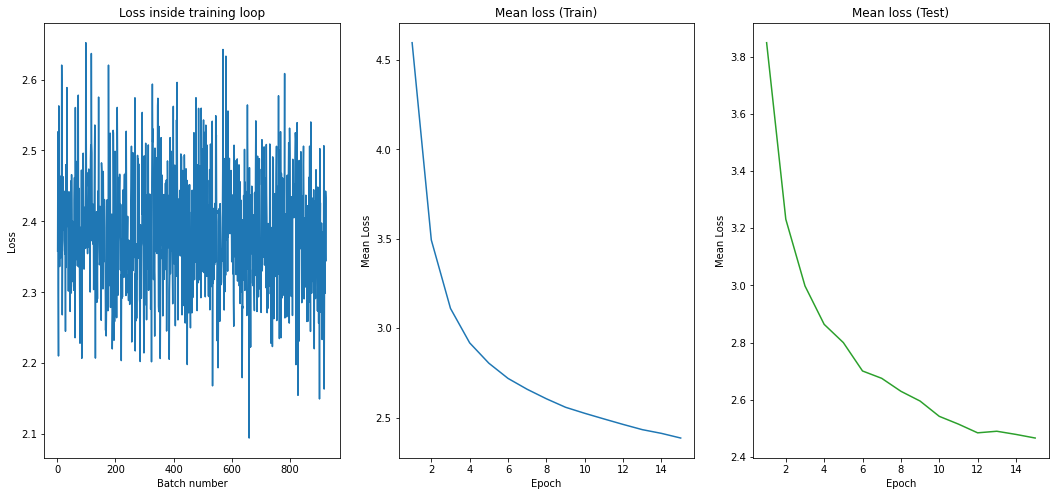

In [28]:
for epoch in range(15):

    network.train(True)

    train_loss_inepoch = []
    test_loss_inepoch = []

    for i, batch in enumerate(dataloader_train):
        img, cap_ix = batch #img size = [batch, 299, 299, 3]
        img = torch.permute(img, (0, 3, 1, 2)) # [batch, 3, 299, 299]
        
        img = img.to(device)
        cap_ix = cap_ix.to(device)

        vectors_8x8, vectors_neck, logits = inception(img)
        vectors_8x8 = torch.permute(vectors_8x8, (0,2,3,1)) #[batch,cnn_features,8,8] ->[batch,8,8,cnn_features]

        optimizer.zero_grad()

        loss = compute_loss(network, vectors_neck, vectors_8x8, cap_ix)
        loss.backward()

        optimizer.step()

        train_loss_inepoch.append(loss.item() / img.size()[0]) # divide loss by the batch size
        if i%10 == 0:
            print_loss(train_loss_inepoch, train_loss, test_loss)

    train_loss.append(np.mean(train_loss_inepoch))
    print_loss(train_loss_inepoch, train_loss, test_loss)

    network.train(False)

    for batch in dataloader_test:
        img, cap_ix = batch #img size = [batch, 299, 299, 3]
        img = torch.permute(img, (0, 3, 1, 2)) # [batch, 3, 299, 299]
        
        img = img.to(device)
        cap_ix = cap_ix.to(device)

        vectors_8x8, vectors_neck, logits = inception(img)
        vectors_8x8 = torch.permute(vectors_8x8, (0,2,3,1)) #[batch,cnn_features,8,8] ->[batch,8,8,cnn_features]

        with torch.no_grad():
            loss = compute_loss(network, vectors_neck, vectors_8x8, cap_ix)

        test_loss_inepoch.append(loss.item() / img.size()[0])
    test_loss.append(np.mean(test_loss_inepoch))
    print_loss(train_loss_inepoch, train_loss, test_loss)
    

In [29]:
torch.save(network.state_dict(), 'best_model_att_1.pt')

In [ ]:
network.load_state_dict(torch.load('best_model_att_1.pt', map_location=device))

<All keys matched successfully>

## Inseption и получение результатов


### Сгенерируем описание

In [64]:
torch.zeros((2,3,4,5))[...,-1].size()

torch.Size([2, 3, 4])

In [67]:
def generate_caption(image, caption_prefix='<bos>', 
                     t=1., sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(device)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        vectors_8x8 = vectors_8x8.permute((0,2,3,1))
        caption_prefix = vocab.sent_to_idx([caption_prefix])

        atts = []
        
        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся

            inwordseq = torch.tensor([caption_prefix]).to(device)   # [batch, sent_len] = [1,caption_prefix_len]
            outword,att = network(vectors_neck, vectors_8x8, inwordseq) # [sent_len, batch, vocab_size] = [caption_prefix_len+1,1,vocab_size]

            atts.append(att[-1].to('cpu').numpy().flatten()) # [64]
            outword = outword.to('cpu')[-1].squeeze()/t             # [vocab_size]
            outword = F.softmax(outword, dim=0)
            if sample == False:
                idx = outword.argmax().item()
            else:
                idx = torch.multinomial(outword, 1).item()
            caption_prefix.append(idx)

            if vocab.words[idx] == vocab.eos:
                break
    return vocab.idx_to_sent(caption_prefix), atts

In [126]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def show_attention(att, img, word):
    darken_layer = Image.new('RGBA', img.size, (0, 0, 0, 170))
    filter = Image.new('RGBA', img.size)
    d = ImageDraw.Draw(filter)
    for i in range(8):
        for j in range(8):
            d.rectangle([0+img.size[0]//8*i, 0+img.size[1]//8*j, 
                        img.size[0]//8*(i+1)-1, img.size[1]//8*(j+1)-1], (255,255,255, int(10*255 * att[i + j*8])))
    darkened_img = Image.alpha_composite(img.convert('RGBA'), darken_layer)
    img_att = Image.alpha_composite(darkened_img, filter)

    #Let's add word at the bottom of the picture with attention weights

    img_cap = img_att.crop((0,0,
              img_att.size[0], img_att.size[1]+25)).convert('RGB')
    font = ImageFont.truetype("Ubuntu-Regular.ttf", 20)
    w,h = font.getsize(word)
    draw = ImageDraw.Draw(img_cap)
    draw.text((img.size[0]//2-w//2, img.size[1]), word, (255,255,255), font)
    return img_cap

### Скачаем пару картинок, чтобы проверить качество:

In [31]:
#sample images

!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O tony_hawk.jpg
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O cat_dog.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Vladimir_Putin_%282018-03-01%29_03_%28cropped%29.jpg/1200px-Vladimir_Putin_%282018-03-01%29_03_%28cropped%29.jpg" -O putin.jpg
!wget "https://pixy.org/src/2/28042.jpg" -O grandpa.jpg
!wget "https://pixy.org/src/38/385694.jpg" -O cycler.jpg
!wget "https://pixy.org/src/32/328718.jpg" -O soccer.jpg

cycler.jpg          100%[===================>]   3.86M   585KB/s    in 11s     

2022-02-14 16:43:45 (372 KB/s) - ‘cycler.jpg’ saved [4045117/4045117]

--2022-02-14 16:43:46--  https://pixy.org/src/32/328718.jpg
Resolving pixy.org (pixy.org)... 198.37.112.17
Connecting to pixy.org (pixy.org)|198.37.112.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481942 (471K) [image/jpeg]
Saving to: ‘soccer.jpg’

soccer.jpg          100%[===================>] 470.65K   286KB/s    in 1.6s    

2022-02-14 16:43:49 (286 KB/s) - ‘soccer.jpg’ saved [481942/481942]



#### Tony Hawk

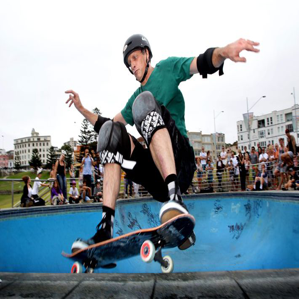

In [188]:
from PIL import Image

img = Image.open('tony_hawk.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [73]:
#Sentence by sampling
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=True)[0][1:-1]))

a man riding a skateboard down a street .
a man is riding a skateboard on a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard down a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard down a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .


In [ ]:
#Greedy sentence
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a man riding a skateboard down a ramp .'

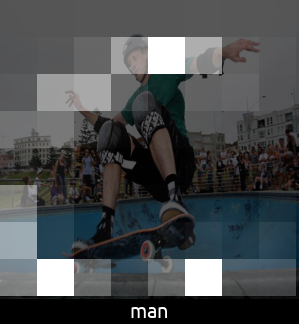

In [194]:
idx = 1

words, att = generate_caption(img_arr, t=0.2, max_len=15, sample=False)
show_attention(att[idx], img, words[idx+1])

#### A cat with a Dog

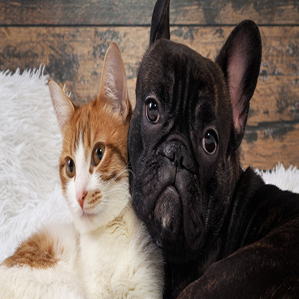

In [180]:
img = Image.open('cat_dog.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.5)[0][1:-1]))

a black and white cat sitting on a table
a black and white cat is next to a white cat .
a cat sitting on a couch with a camera
a cat that is sitting on a couch
a black and white cat is sitting in a box
a black and white cat is looking at a camera .
a cat is sitting on a couch with a white frisbee .
a cat standing on a couch with a bottle of water .
a black and white cat and a red cat .
a black and white cat is standing in a room .


In [ ]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a cat is sitting on a couch .'

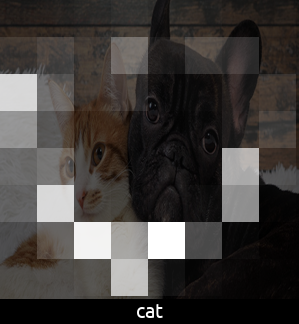

In [187]:
idx = 1

words, att = generate_caption(img_arr, t=0.2, max_len=15, sample=False)
show_attention(att[idx], img, words[idx+1])

#### Mr. President

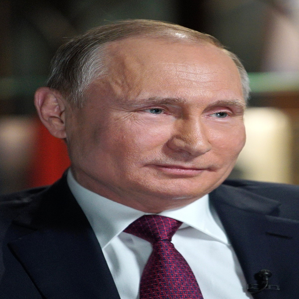

In [175]:
img = Image.open('putin.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, sample=True)[0][1:-1]))

a man in a suit and tie in a suit .
a man in a suit and tie standing in a room .
a man in a suit and tie in a suit .
a man wearing a tie and a tie and a suit .
a man in a suit and tie in a suit .
a man wearing a tie and a suit and tie .
a man in a suit and tie is standing in a suit .
a man wearing a suit and tie with a tie .
a man wearing a suit and tie with a tie .
a man wearing a suit and tie with a tie .


In [ ]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a man in a suit and tie in a suit .'

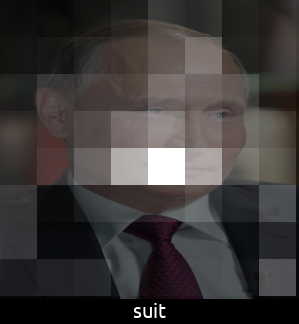

In [179]:
idx = 4

words, att = generate_caption(img_arr, t=0.2, max_len=15, sample=False)
show_attention(att[idx], img, words[idx+1])

#### Cycler

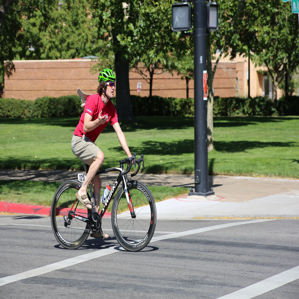

In [167]:
img = Image.open('cycler.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, sample=True)[0][1:-1]))

a man riding a bike down a street .
a man riding a bike down a street .
a man riding a bike down a street .
a man riding a bike down a street .
a man riding a bike down a street .
a man riding a bike down a street .
a man riding a bike down a street .
a woman riding a bike down a street .
a man riding a bike down a street .
a person riding a bike on a street .


In [132]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a man riding a bike down a street next to a bike .'

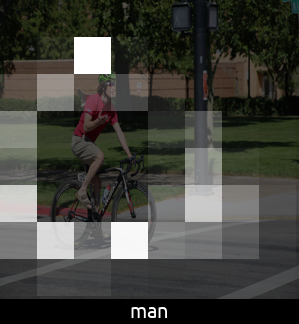

In [174]:
idx = 1

words, att = generate_caption(img_arr, t=0.2, max_len=15, sample=False)
show_attention(att[idx], img, words[idx+1])

#### Soccer 

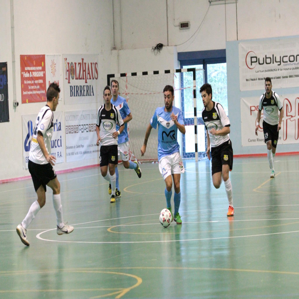

In [160]:
img = Image.open('soccer.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.2, sample=True)[0][1:-1]))

a group of men playing soccer on a soccer field .
a group of people standing around a table with a cake .
a group of people standing around a small boy .
a group of people standing around a soccer ball .
a group of people standing around a table with a tennis racket .
a group of people standing around a tennis player .
a group of people standing around a soccer ball .
a group of people standing around a man on a bench .
a group of people standing around a man on a bench .
a group of people standing around a table with a cake .


In [ ]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a group of people standing around a man and a woman .'

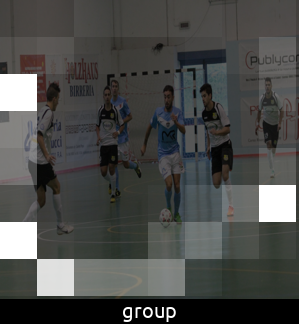

In [166]:
idx = 1

words, att = generate_caption(img_arr, t=0.2, max_len=15, sample=False)
show_attention(att[idx], img, words[idx+1])

#### Grandpa

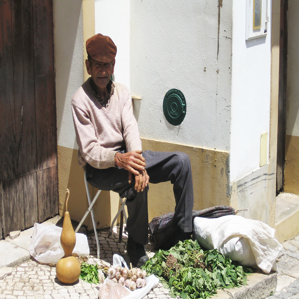

In [147]:
img = Image.open('grandpa.jpg').convert('RGB').resize((299,299))
img_arr = np.array(img).astype('float32') / 255.
img

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img_arr, t=0.4, sample=True)[0][1:-1]))

a man and a woman sitting at a table .
a man in a green shirt and a white plate and a table
a man in a kitchen preparing a meal .
a man in a kitchen putting a bowl and a bowl of food .
a man in a hat sitting at a table with a cake .
a man in a kitchen with a bowl full of food .
a man in a red shirt is preparing food .
a man in a suit and a tie in a kitchen .
a man standing in a kitchen holding a bowl full of food .
a man in a white shirt and a tie in a kitchen .


In [150]:
' '.join(generate_caption(img_arr, t=0.2, max_len=15, sample=False)[0][1:-1])

'a man is sitting at a table with a plate of food .'

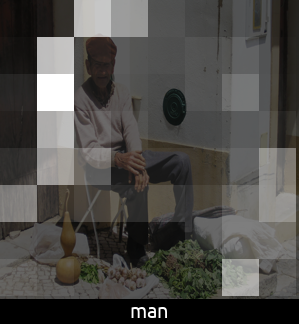

In [159]:
idx = 1

words, att = generate_caption(img_arr, t=0.2, max_len=15, sample=False)
show_attention(att[idx], img, words[idx+1])

Upload all files to Google drive

In [ ]:
drive.flush_and_unmount()